# Задание 1
Каждая строчка датасета - пост из твиттера, два класса: катастрофа и нет
1. Необходимо очистить данные от лишних символов и стоп-слов. 
2. Построить информативные графики, демонстрирующие специфику датасета.
3. Применить 3 способа токенизации (по словам, bpe, berttokenizer)
4. Сделать одну векторизацию и 2 варианта эмбеддингов. Один из алгоритмов эмбеддингов предобученная модель (huggingface).  
5. Визуализировать близость получившихся эмбеддингов, цветами окрасить разные классы. Можно применить PCA перед отрисовкой
6. Для каждой используемой технологии в комментариях около ячейки с кодом написать своими словами принцип (идею) алгоритма. Описания похожие на текст от GPT приниматься не будут.
7. Выложить на github

Импортируем необходимые для дальнейшей работы библиотеки

In [1]:
%pip install langid pandas nltk seaborn matplotlib sentencepiece

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import langid
import nltk
import re

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Прочитаем файл датасета в pandas датафрейм


In [2]:
df = pd.read_csv('socialmedia_relevant_cols.csv', encoding='unicode_escape')
df.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


Добавим столбец с длинной каждого твита и рассмотрим его

In [3]:
df["text_length"] = df["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df["text_length"].describe())

Train Length Stat
count    10876.000000
mean       101.725634
std         34.118877
min          5.000000
25%         78.000000
50%        108.000000
75%        134.000000
max        168.000000
Name: text_length, dtype: float64


Проанализируем язык твитов в датасете \
Т.к. nlkt.TextCat() использует в себе анализ n-грам, получается, что он намного эффективнее работает на коротких сообщениях по сравнению с langid. Но на длинных текстах он становится чересчур сложным и в разы дольше работает. Поэтому в идеале можно применять для коротких текстов nlkt, а для длинных langid или комбинировать их.

In [4]:
from nltk.classify.textcat import TextCat # language identification from NLTK
nltk.download('crubadan')
nltk.download('punkt')
tc = TextCat()
langid_guess = df['text'].apply(langid.classify)
tc_guess = df['text'][0:50].apply(tc.guess_language)

[nltk_data] Downloading package crubadan to /home/lockr/nltk_data...
[nltk_data]   Package crubadan is already up-to-date!
[nltk_data] Downloading package punkt to /home/lockr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df[0:50][tc_guess.apply(lambda x: x!='eng')]

,text,choose_one,class_label,text_length
6,"13,000 people receive #wildfires evacuation or...",Relevant,1,65
11,Typhoon Soudelor kills 28 in China and Taiwan,Relevant,1,45
14,There's an emergency evacuation happening now ...,Relevant,1,79
19,#Flood in Bago Myanmar #We arrived Bago,Relevant,1,39
20,Damage to school bus on 80 in multi car crash ...,Relevant,1,56
28,What a goooooooaaaaaal!!!!!!,Not Relevant,0,28
29,Fuck off!,Not Relevant,0,9
31,this is ridiculous....,Not Relevant,0,22
33,Love skiing,Not Relevant,0,11
36,LOOOOOOL,Not Relevant,0,8


In [6]:

df[0:50][langid_guess[0:50].apply(lambda x: x[0]!='en')]

,text,choose_one,class_label,text_length
4,Forest fire near La Ronge Sask. Canada,Relevant,1,38
18,#raining #flooding #Florida #TampaBay #Tampa 1...,Relevant,1,76
24,I love fruits,Not Relevant,0,13
33,Love skiing,Not Relevant,0,11
41,Do you like pasta?,Not Relevant,0,18


В нашем же случае можно заметить, что все твиты, даже ошибочно признанные не английским - все-таки написаны на английском языке.

## Предобработка

Создадим колонку, в которой будет обрабатывать текст

In [7]:
df['cleaned_text'] = df['text'].copy()

Избавимся от остатков юникода

In [8]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x :x.encode("utf8").decode("utf8"))


Удалим ссылки из данных

In [9]:
def remove_url(text):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)

df['cleaned_text'] = df['cleaned_text'].apply(remove_url)
print(df.text[10871], df.class_label[10871])

M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ 1


Далее делом удалим знаки препинания и хэштеги

прощайте текстовые смайлики :( 

In [10]:
import string
def removing_symbols(text):
    symbols = string.punctuation + string.digits
    return text.translate(str.maketrans('', '', symbols))

df["cleaned_text"] = df["cleaned_text"].apply(removing_symbols)

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords


nltk.download('stopwords')
print(len(set(stopwords.words('english'))), len(ENGLISH_STOP_WORDS))


179 318


[nltk_data] Downloading package stopwords to /home/lockr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import re

def removing_sw(text):
    return " ".join([word for word in re.split("\W+",text) if word.lower() not in ENGLISH_STOP_WORDS])

df['cleaned_text'] = df['cleaned_text'].apply(removing_sw)

In [13]:
df['cleaned_text'] = df['cleaned_text'].apply(str.lower)
df['cleaned_text_length'] = df["cleaned_text"].apply(lambda x : len(x))
df['cleaned_text_length'].describe()

count    10876.000000
mean        62.031629
std         24.125197
min          0.000000
25%         44.000000
50%         63.000000
75%         80.000000
max        138.000000
Name: cleaned_text_length, dtype: float64

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join(list(map(lemmatizer.lemmatize, word_tokenize(x)))))


[nltk_data] Downloading package wordnet to /home/lockr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r"(.)\1\1+",r'\1\1', x).replace('\n', ' '))


In [16]:
df.dropna(inplace=True)
df.drop_duplicates(subset="text",inplace=True)
df.drop_duplicates(subset="cleaned_text",inplace=True)
df = df[~(df['class_label'] == 2)]
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)


In [17]:

df.head()

,text,choose_one,class_label,text_length,cleaned_text,cleaned_text_length
0,Just happened a terrible car crash,Relevant,1,34,just happened terrible car crash,32
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,69,deed reason earthquake allah forgive,37
2,"Heard about #earthquake is different cities, s...",Relevant,1,64,heard earthquake different city stay safe,43
3,"there is a forest fire at spot pond, geese are...",Relevant,1,96,forest spot pond goose fleeing street save,42
4,Forest fire near La Ronge Sask. Canada,Relevant,1,38,forest near la ronge sask canada,32


In [18]:
df['cleaned_text'].describe()

count                                 9617
unique                                9617
top       just happened terrible car crash
freq                                     1
Name: cleaned_text, dtype: object

## Графики

,choose_one,% of Count
choose_one,,
Not Relevant,5683,59.093272
Relevant,3934,40.906728


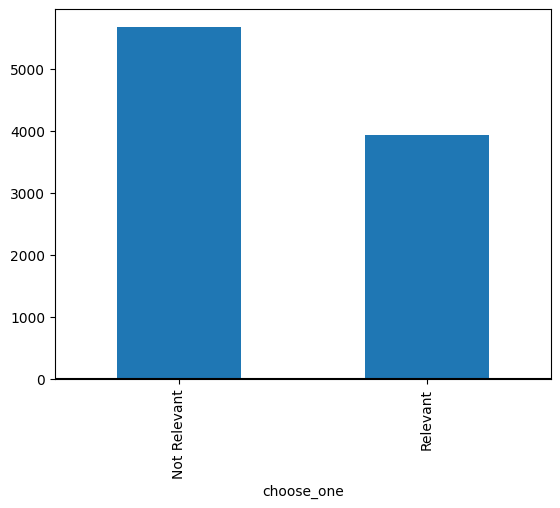

In [19]:
def count_table(df, c):
        count = df[c].value_counts()
        count_percent = 100 * count / len(df)
        count_table = pd.concat([count, count_percent], axis=1)
        
        count_table.columns = [c, '% of Count']
        count_table.round(2)

        gb = df.groupby(df[c])
        targetEDA=gb[c].aggregate(len)
        
        plt.figure()
        targetEDA.plot(kind='bar', grid=False)
        plt.axhline(0, color='k')
        
        return count_table

count_table(df, 'choose_one')

Text(0.5, 1.0, 'Length diff')

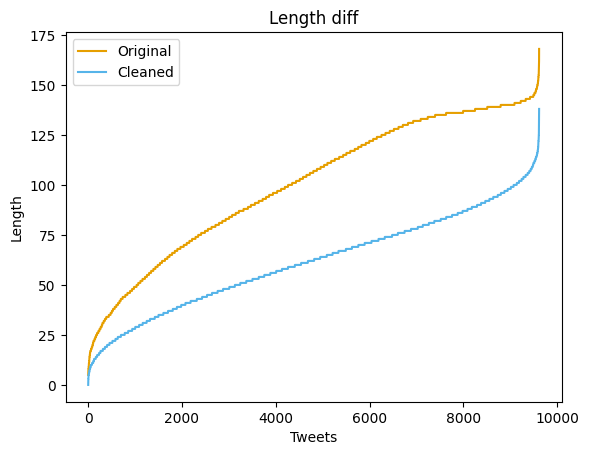

In [20]:
# Make a separate list for each airline
x1 = sorted(list(df['text_length']))
x2 = sorted(list(df['cleaned_text_length']))

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Original', 'Cleaned']

# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.plot(x1, color = colors[0], label=names[0])
plt.plot(x2, color = colors[1], label=names[1])
# Plot formatting
plt.legend()
plt.xlabel('Tweets')
plt.ylabel('Length')
plt.title('Length diff')

## Токенизация

### Word Tokenize

In [21]:
import nltk
from nltk.tokenize import word_tokenize


nltk.download('punkt')

df['word_tokens'] = df['cleaned_text'].apply(word_tokenize)
df[['word_tokens']]

[nltk_data] Downloading package punkt to /home/lockr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,word_tokens
0,"[just, happened, terrible, car, crash]"
1,"[deed, reason, earthquake, allah, forgive]"
2,"[heard, earthquake, different, city, stay, safe]"
3,"[forest, spot, pond, goose, fleeing, street, s..."
4,"[forest, near, la, ronge, sask, canada]"
...,...
9612,"[official, say, quarantine, place, alabama, ho..."
9613,"[flip, im, walmart, bomb, evacuate, stay, tune..."
9614,"[suicide, bomber, kill, saudi, security, site,..."
9615,"[green, line, derailment, chicago]"


Еще нашел токенайзер, который заточен под работу с твитами. Достойно упоминания, т.к. хорошо подходит для работы с твиттерской лексикой

In [22]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer(reduce_len=True, preserve_case=False, strip_handles=True)

df['tw_tokens'] = df['text'].apply(tknzr.tokenize)
df[['tw_tokens']]

,tw_tokens
0,"[just, happened, a, terrible, car, crash]"
1,"[our, deeds, are, the, reason, of, this, #eart..."
2,"[heard, about, #earthquake, is, different, cit..."
3,"[there, is, a, forest, fire, at, spot, pond, ,..."
4,"[forest, fire, near, la, ronge, sask, ., canada]"
...,...
9612,"[officials, say, a, quarantine, is, in, place,..."
9613,"[on, the, flip, side, i'm, at, walmart, and, t..."
9614,"[suicide, bomber, kills, 15, in, saudi, securi..."
9615,"[green, line, derailment, in, chicago, http://..."


### BPE


In [23]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import PreTrainedTokenizerFast


/home/lockr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:

raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

In [25]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=30522, special_tokens=special_tokens)


In [26]:
dataset = df.copy()
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["cleaned_text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

In [27]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [28]:
df['bpe_tokens'] = df['cleaned_text'].apply(tokenizer.tokenize)
df[['bpe_tokens']]

,bpe_tokens
0,"[Ġjust, Ġhappened, Ġterrible, Ġcar, Ġcrash]"
1,"[Ġdeed, Ġreason, Ġearthquake, Ġallah, Ġforgive]"
2,"[Ġheard, Ġearthquake, Ġdifferent, Ġcity, Ġstay..."
3,"[Ġforest, Ġspot, Ġpond, Ġgoose, Ġfleeing, Ġstr..."
4,"[Ġforest, Ġnear, Ġla, Ġronge, Ġsask, Ġcanada]"
...,...
9612,"[Ġofficial, Ġsay, Ġquarantine, Ġplace, Ġalabam..."
9613,"[Ġflip, Ġim, Ġwalmart, Ġbomb, Ġevacuate, Ġstay..."
9614,"[Ġsuicide, Ġbomber, Ġkill, Ġsaudi, Ġsecurity, ..."
9615,"[Ġgreen, Ġline, Ġderailment, Ġchicago]"


### BertTokenizer

In [29]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['bert_tokens'] = df['cleaned_text'].apply(tokenizer.tokenize)
df[['bert_tokens']]


,bert_tokens
0,"[just, happened, terrible, car, crash]"
1,"[deed, reason, earthquake, allah, forgive]"
2,"[heard, earthquake, different, city, stay, safe]"
3,"[forest, spot, pond, goose, fleeing, street, s..."
4,"[forest, near, la, ron, ##ge, sas, ##k, canada]"
...,...
9612,"[official, say, qu, ##aran, ##tine, place, ala..."
9613,"[flip, im, wal, ##mart, bomb, evacuate, stay, ..."
9614,"[suicide, bomber, kill, saudi, security, site,..."
9615,"[green, line, der, ##ail, ##ment, chicago]"


## Векторизация


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
%pip install yellowbrick
from sklearn.decomposition import PCA, TruncatedSVD
from yellowbrick.text import TSNEVisualizer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/home/lockr/.local/lib/python3.10/site-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


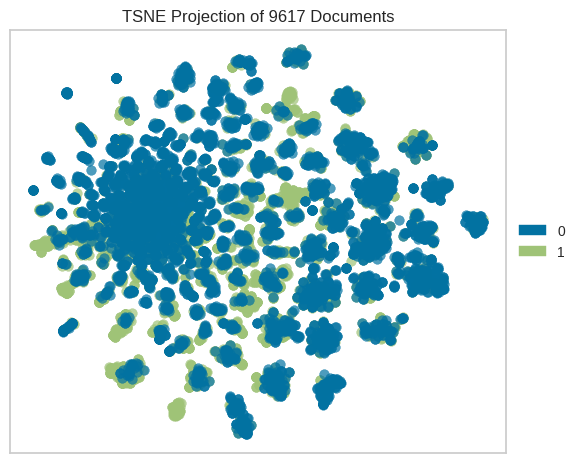

<Axes: title={'center': 'TSNE Projection of 9617 Documents'}>

In [31]:

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X, tfidf_vectorizer = tfidf(df["cleaned_text"])

y = df.class_label

visualizer = TSNEVisualizer()
visualizer.fit_transform(X, y)
visualizer.show()

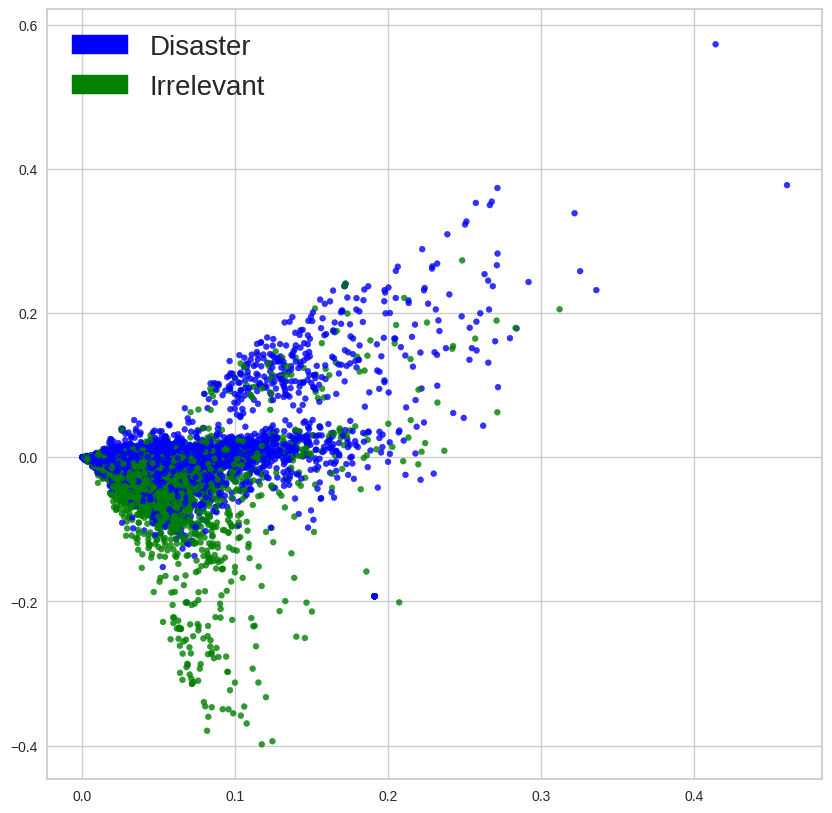

In [32]:

def plot_LSA(y_train, lsa_scores):
    colors = ['blue','green']

    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=18, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
    
    blue_patch = mpatches.Patch(color='blue', label='Disaster')
    green_patch = mpatches.Patch(color='green', label='Irrelevant')
    plt.legend(handles=[blue_patch, green_patch], prop={'size': 20})


svd = TruncatedSVD(n_components=2)
lsa_tfidf = svd.fit_transform(X, y)
               
fig = plt.figure(figsize=(10, 10))         
plot_LSA(y, lsa_tfidf)
plt.show()

### Эмбеддинги


In [33]:
%pip install gensim

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [35]:
def get_word2vec_embeddings(vectors, data, generate_missing=False, k=300):
    embeddings = data['word_tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [36]:
from gensim.models import word2vec
model = word2vec.Word2Vec(df['word_tokens'])

/home/lockr/.local/lib/python3.10/site-packages/paramiko/transport.py:178: CryptographyDeprecationWarning: Blowfish has been deprecated
  'class': algorithms.Blowfish,


In [37]:
our_wv_embd = get_word2vec_embeddings(model.wv, df, k=100)
our_wv_embd = np.array(our_wv_embd)



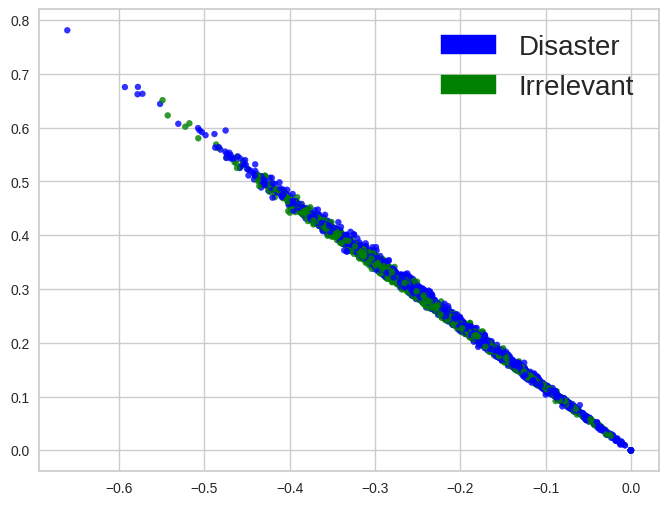

In [38]:
fig = plt.figure(figsize=(8, 6))         
plot_LSA(y, our_wv_embd)
plt.show()

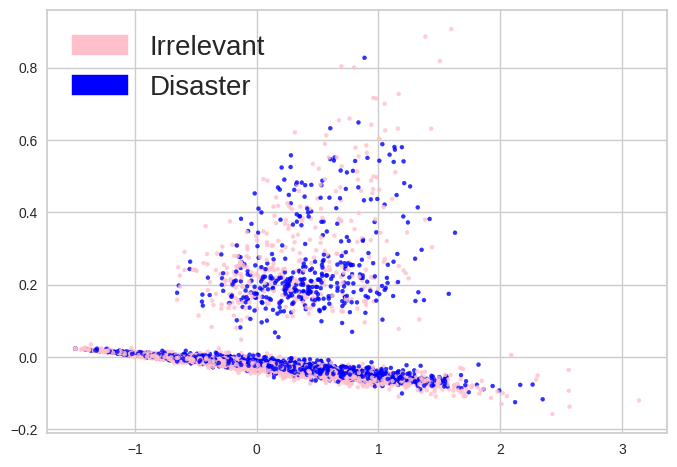

<Figure size 1500x1500 with 0 Axes>

In [39]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(our_wv_embd, df['class_label'])
color_mapper = {label:idx for idx, label in enumerate(set(y))}
color_column = [color_mapper[label] for label in y]
colors = ['pink','blue']


plt.scatter(pca_result[:, 0], pca_result[:, 1], s=8, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))      
plt.show()

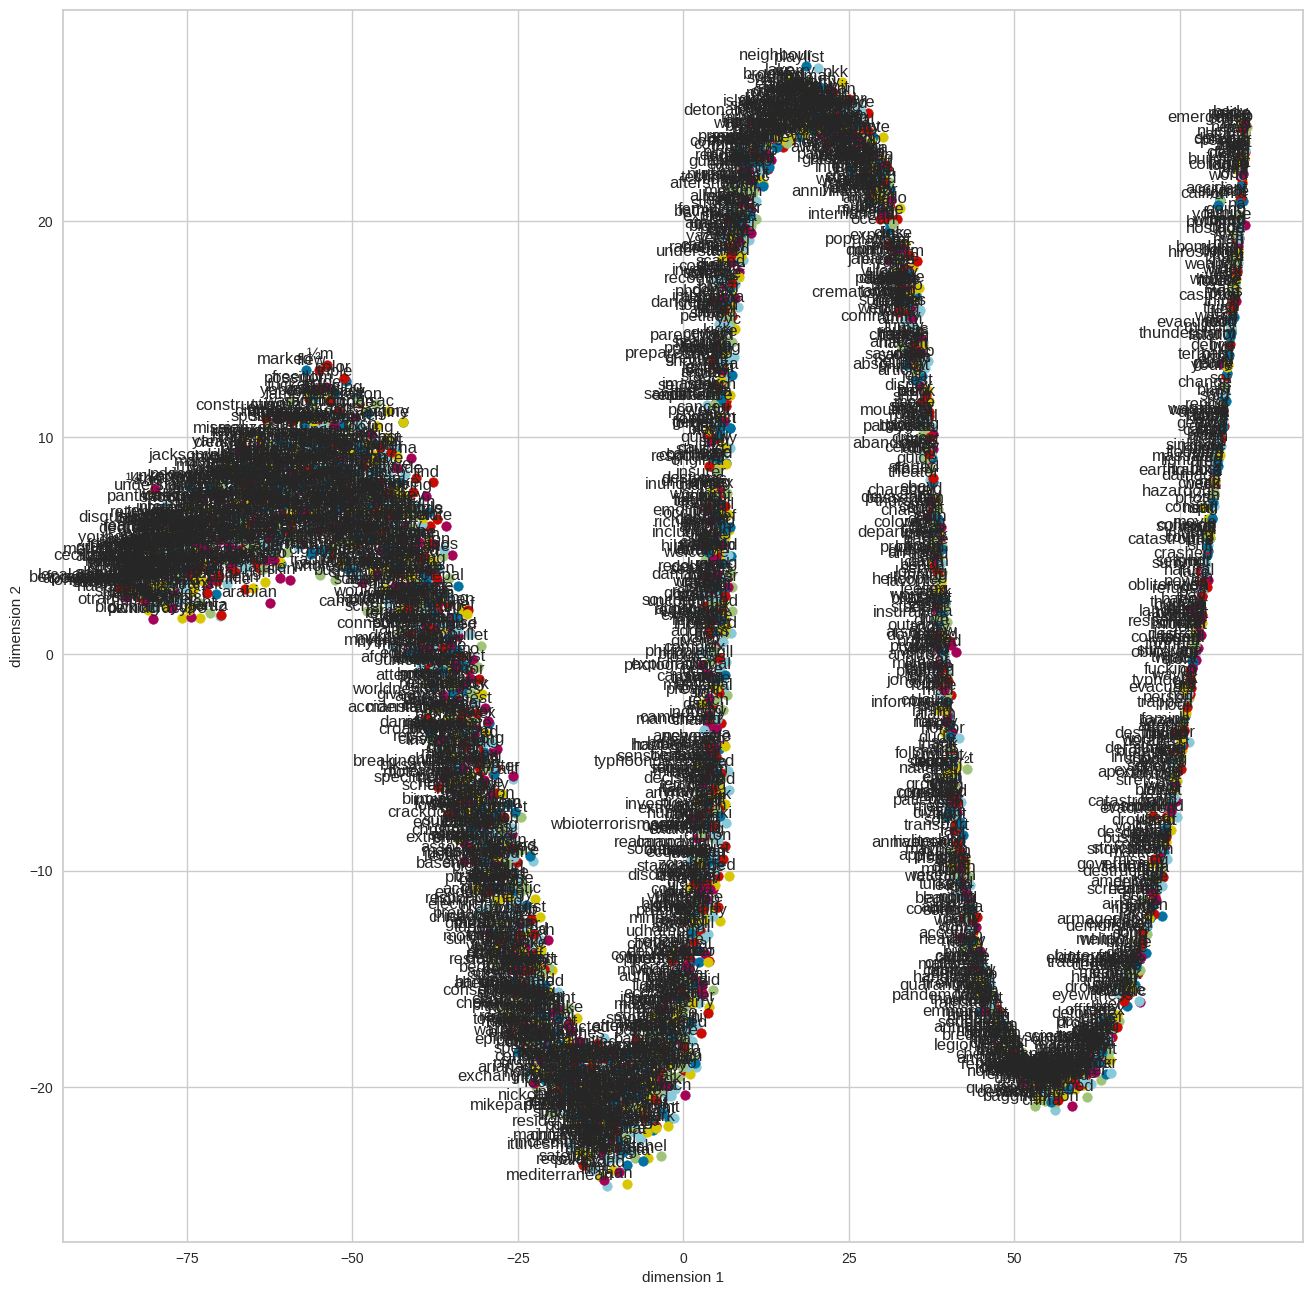

In [40]:
from sklearn.manifold import TSNE


def tsne_plot(model):
    labels = []
    tokens = []
    
    # Extracting words and their vectors from our trained model 
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    # Train t-SNE 
    tsne_model = TSNE(perplexity=45, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
    plt.show()

tsne_plot(model)

In [41]:

import gensim.downloader as api

# takes 3-10 minutes to load
wv = api.load('word2vec-google-news-300') 

In [42]:
embeddings = get_word2vec_embeddings(wv, df)
embeddings = np.array(embeddings)


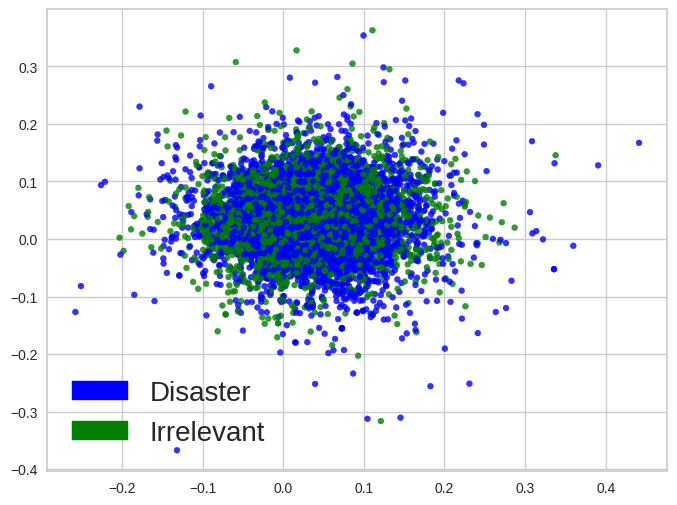

In [43]:
fig = plt.figure(figsize=(8, 6))         
plot_LSA(y, embeddings)
plt.show()

In [44]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings, df['class_label'])

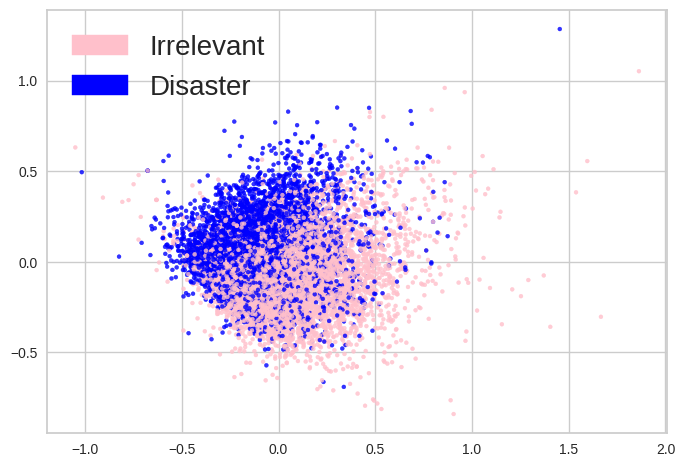

<Figure size 1500x1500 with 0 Axes>

In [45]:
color_mapper = {label:idx for idx, label in enumerate(set(y))}
color_column = [color_mapper[label] for label in y]
colors = ['pink','blue']


plt.scatter(pca_result[:, 0], pca_result[:, 1], s=8, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))      
plt.show()

### Модель с hugging face

In [46]:
%pip install transformers
%pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [47]:

from transformers import AutoModel

model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method
embeddings = model.encode(df['cleaned_text'],
    max_length=281) #новое ограничение по количеству символов в твитере


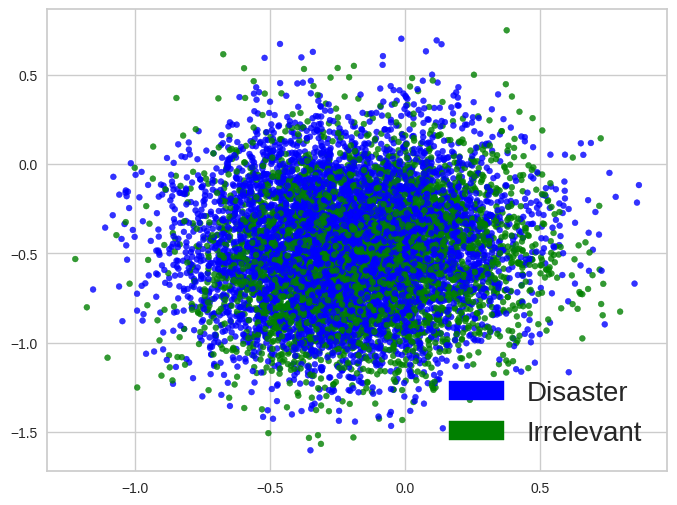

In [48]:
fig = plt.figure(figsize=(8, 6))         
plot_LSA(y, embeddings)
plt.show()

In [49]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings, df['class_label'])

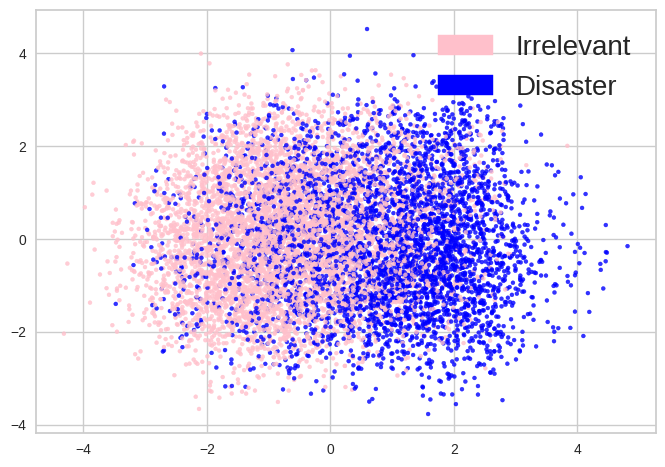

<Figure size 1500x1500 with 0 Axes>

In [50]:
color_mapper = {label:idx for idx, label in enumerate(set(y))}
color_column = [color_mapper[label] for label in y]
colors = ['pink','blue']


plt.scatter(pca_result[:, 0], pca_result[:, 1], s=8, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))      
plt.show()